# Introduction

`pandora-sat` is a respository for information about the Pandora spacecraft, its detectors, and its orbit. It holds information on the spacecraft that is independent of pointing and target. This package is continually updated with the most current information on Pandora.

In [2]:
import pandorasat as ps
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
plt.style.use(ps.PANDORASTYLE)

You can initialize the observatory using

In [3]:
p = ps.PandoraSat()

This object acts as a container of the different observatory components: the visible detector (VISDA), the NIR detector (NIRDA), the optics and hardware of the spacecraft (Hardware), and the orbit of the spacecraft (Orbit). You can access each of these components via the following

In [4]:
visda = p.VISDA
nirda = p.NIRDA
hardware = p.Hardware
orbit = p.Orbit

Each of these objects contains information on each of their respective components. Many of these are very useful quantities such as the pixel_scale of the detectors or the period of the orbit. For example, we can take a look at some of this info using

In [5]:
# This will print the pixel scale of the NIR detector
print(p.NIRDA.pixel_size)

# This will print the number of columns of the visible detector
print(p.VISDA.naxis1)
# and the number of rows of the visible detector
print(p.VISDA.naxis2)

# This will print the mirror diameter of Pandora's mirror
print(p.Hardware.mirror_diameter)

# This will print Pandora's orbital period
print(p.Orbit.period)

18.0 um / pix
2048.0 pix
2048.0 pix
0.4264141179651537 m
90.0 min


In addition to standalone values, `pandora-sat` contains useful functions that do thing such as describe the sensitivity of the detectors, convert between magnitude and flux, or estimate the throughput of a detector. Say we wanted to fetch the sensitivity of the NIR and Visible detectors then plot them for easy viewing. We would do that as follows

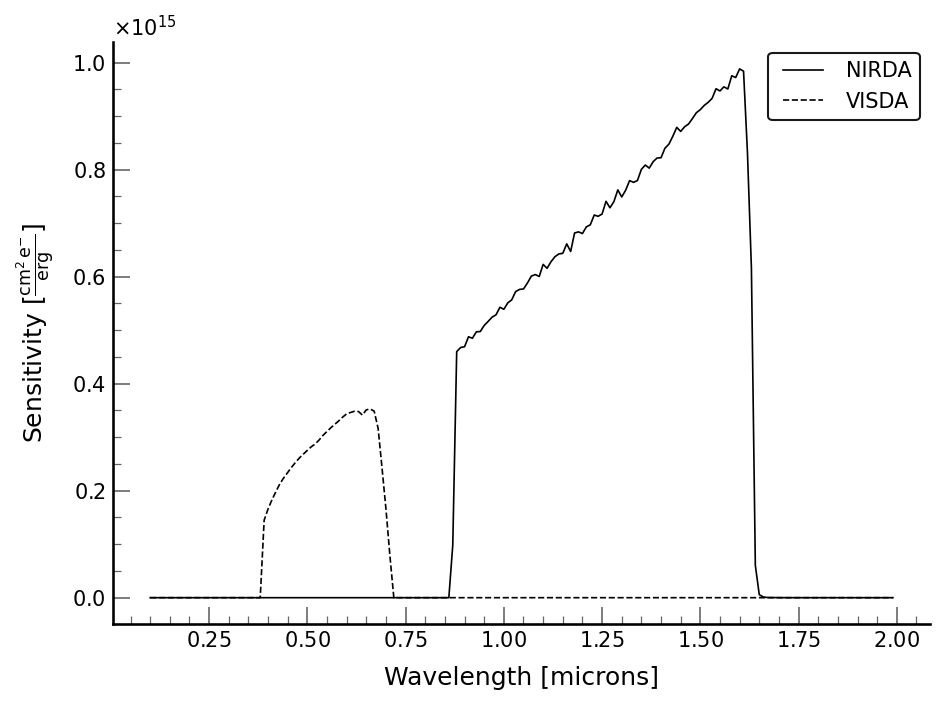

In [6]:
w = np.arange(0.1, 2, 0.01) * u.micron
fig, ax = plt.subplots()
ax.plot(w, nirda.sensitivity(w), label='NIRDA', c='k', ls='-')
ax.plot(w, visda.sensitivity(w), label='VISDA', c='k', ls='--')
ax.set(xlabel='Wavelength [microns]', ylabel=f"Sensitivity [{nirda.sensitivity(w).unit.to_string('latex')}]")
plt.legend()

Likewise, we can plot the throughput of the two detectors across the same wavelength regime like so

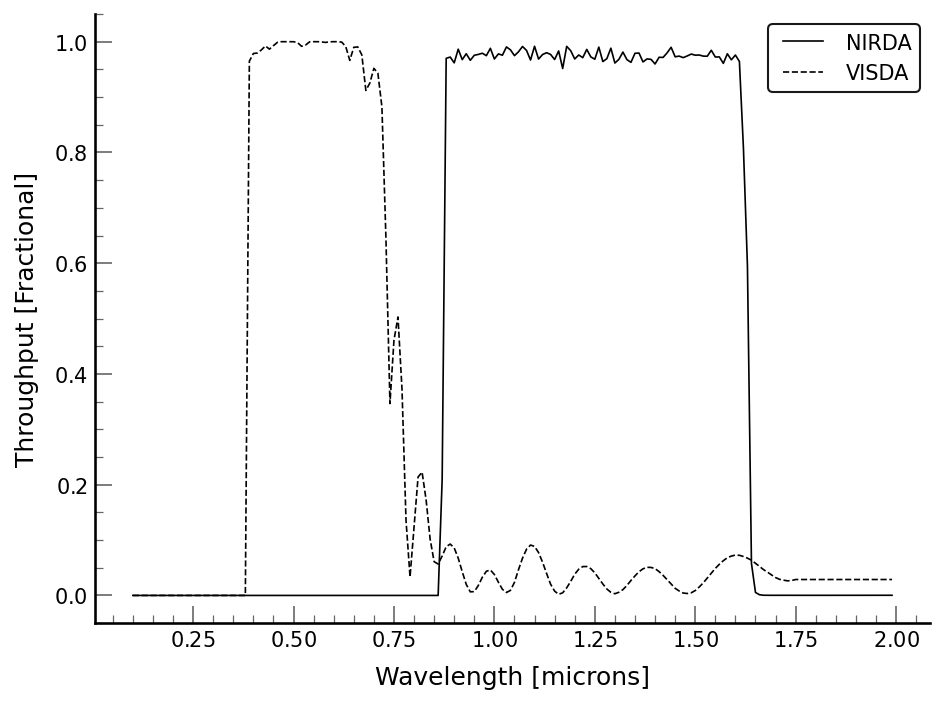

In [7]:
fig, ax = plt.subplots()
ax.plot(w, nirda.throughput(w), label='NIRDA', c='k', ls='-')
ax.plot(w, visda.throughput(w), label='VISDA', c='k', ls='--')
ax.set(xlabel='Wavelength [microns]', ylabel=f"Throughput [Fractional]")
plt.legend()

You can also convert between flux and magnitude on both of Pandora's detectors.

In [8]:
nirda.flux_from_mag(10)

<Quantity 3.19633929e-14 erg / (Angstrom s cm2)>

In [9]:
visda.flux_from_mag(10)

<Quantity 3.77670343e-13 erg / (Angstrom s cm2)>

In [10]:
nirda.mag_from_flux(1e-15 * u.erg/(u.AA * u.s * u.cm**2))

<Quantity 13.76163218>

In [11]:
visda.mag_from_flux(1e-15 * u.erg/(u.AA * u.s * u.cm**2))

<Quantity 16.44278221>